# Análisis Exploratorio de Datos (EDA) - Employee Attrition

Este notebook contiene el análisis exploratorio completo del dataset de deserción laboral de empleados.


In [90]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Cargar los datos
df = pd.read_csv('../Data/csv/WA_Fn-UseC_-HR-Employee-Attrition.csv')
print(f"Dataset cargado: {df.shape[0]} filas y {df.shape[1]} columnas")
df.head()


Dataset cargado: 1470 filas y 35 columnas


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## a) Encontrar porcentaje de nulos


In [91]:
# Análisis de valores nulos
null_percentage = (df.isnull().sum() / len(df)) * 100
null_df = pd.DataFrame({
    'Columna': null_percentage.index,
    'Porcentaje_Nulos': null_percentage.values
})
null_df = null_df[null_df['Porcentaje_Nulos'] > 0].sort_values('Porcentaje_Nulos', ascending=False)

print("=== ANÁLISIS DE VALORES NULOS ===")
if len(null_df) == 0:
    print(" No hay valores nulos en el dataset")
else:
    print(null_df)

# Verificar también valores vacíos o espacios en blanco
empty_strings = df.apply(lambda x: (x == '').sum() if x.dtype == 'object' else 0)
print(f"\nValores de cadena vacía encontrados: {empty_strings.sum()}")


=== ANÁLISIS DE VALORES NULOS ===
 No hay valores nulos en el dataset

Valores de cadena vacía encontrados: 0


## b) Encontrar porcentaje de "0's" y ver si tiene sentido tenerlos en variables numéricas


In [92]:
# Identificar variables numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Variables numéricas: {numeric_columns}")

# Análisis de ceros en variables numéricas
zero_analysis = []
for col in numeric_columns:
    zero_count = (df[col] == 0).sum()
    zero_percentage = (zero_count / len(df)) * 100
    zero_analysis.append({
        'Variable': col,
        'Cantidad_Ceros': zero_count,
        'Porcentaje_Ceros': zero_percentage,
        'Tiene_Sentido_Ceros': 'Sí' if zero_count > 0 else 'No'
    })

zero_df = pd.DataFrame(zero_analysis)
zero_df = zero_df[zero_df['Cantidad_Ceros'] > 0].sort_values('Porcentaje_Ceros', ascending=False)

print("\n=== ANÁLISIS DE CEROS EN VARIABLES NUMÉRICAS ===")
print(zero_df)

# Análisis específico de variables con muchos ceros
print("\n=== JUSTIFICACIÓN DE CEROS ===")
for _, row in zero_df.iterrows():
    var = row['Variable']
    pct = row['Porcentaje_Ceros']
    
    if var in ['YearsSinceLastPromotion', 'YearsInCurrentRole']:
        print(f"{var}: {pct:.1f}% - Tiene sentido (empleados nuevos o sin promociones)")
    elif var in ['DistanceFromHome']:
        print(f"{var}: {pct:.1f}% - Posible error de datos (distancia no puede ser 0)")
    elif var in ['NumCompaniesWorked']:
        print(f"{var}: {pct:.1f}% - Tiene sentido (primer trabajo)")
    else:
        print(f"{var}: {pct:.1f}% - Revisar si tiene sentido lógico")


Variables numéricas: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

=== ANÁLISIS DE CEROS EN VARIABLES NUMÉRICAS ===
                   Variable  Cantidad_Ceros  Porcentaje_Ceros  \
18         StockOptionLevel             631         42.925170   
24  YearsSinceLastPromotion             581         39.523810   
25     YearsWithCurrManager             263         17.891156   
23       YearsInCurrentRole             244         16.598639   
13       NumCompaniesWorked             197         13.401361   
20    TrainingTimesLastYear              54

## c) Generar los gráficos correspondientes (histogramas, barras, correlación, etc) de cada variable


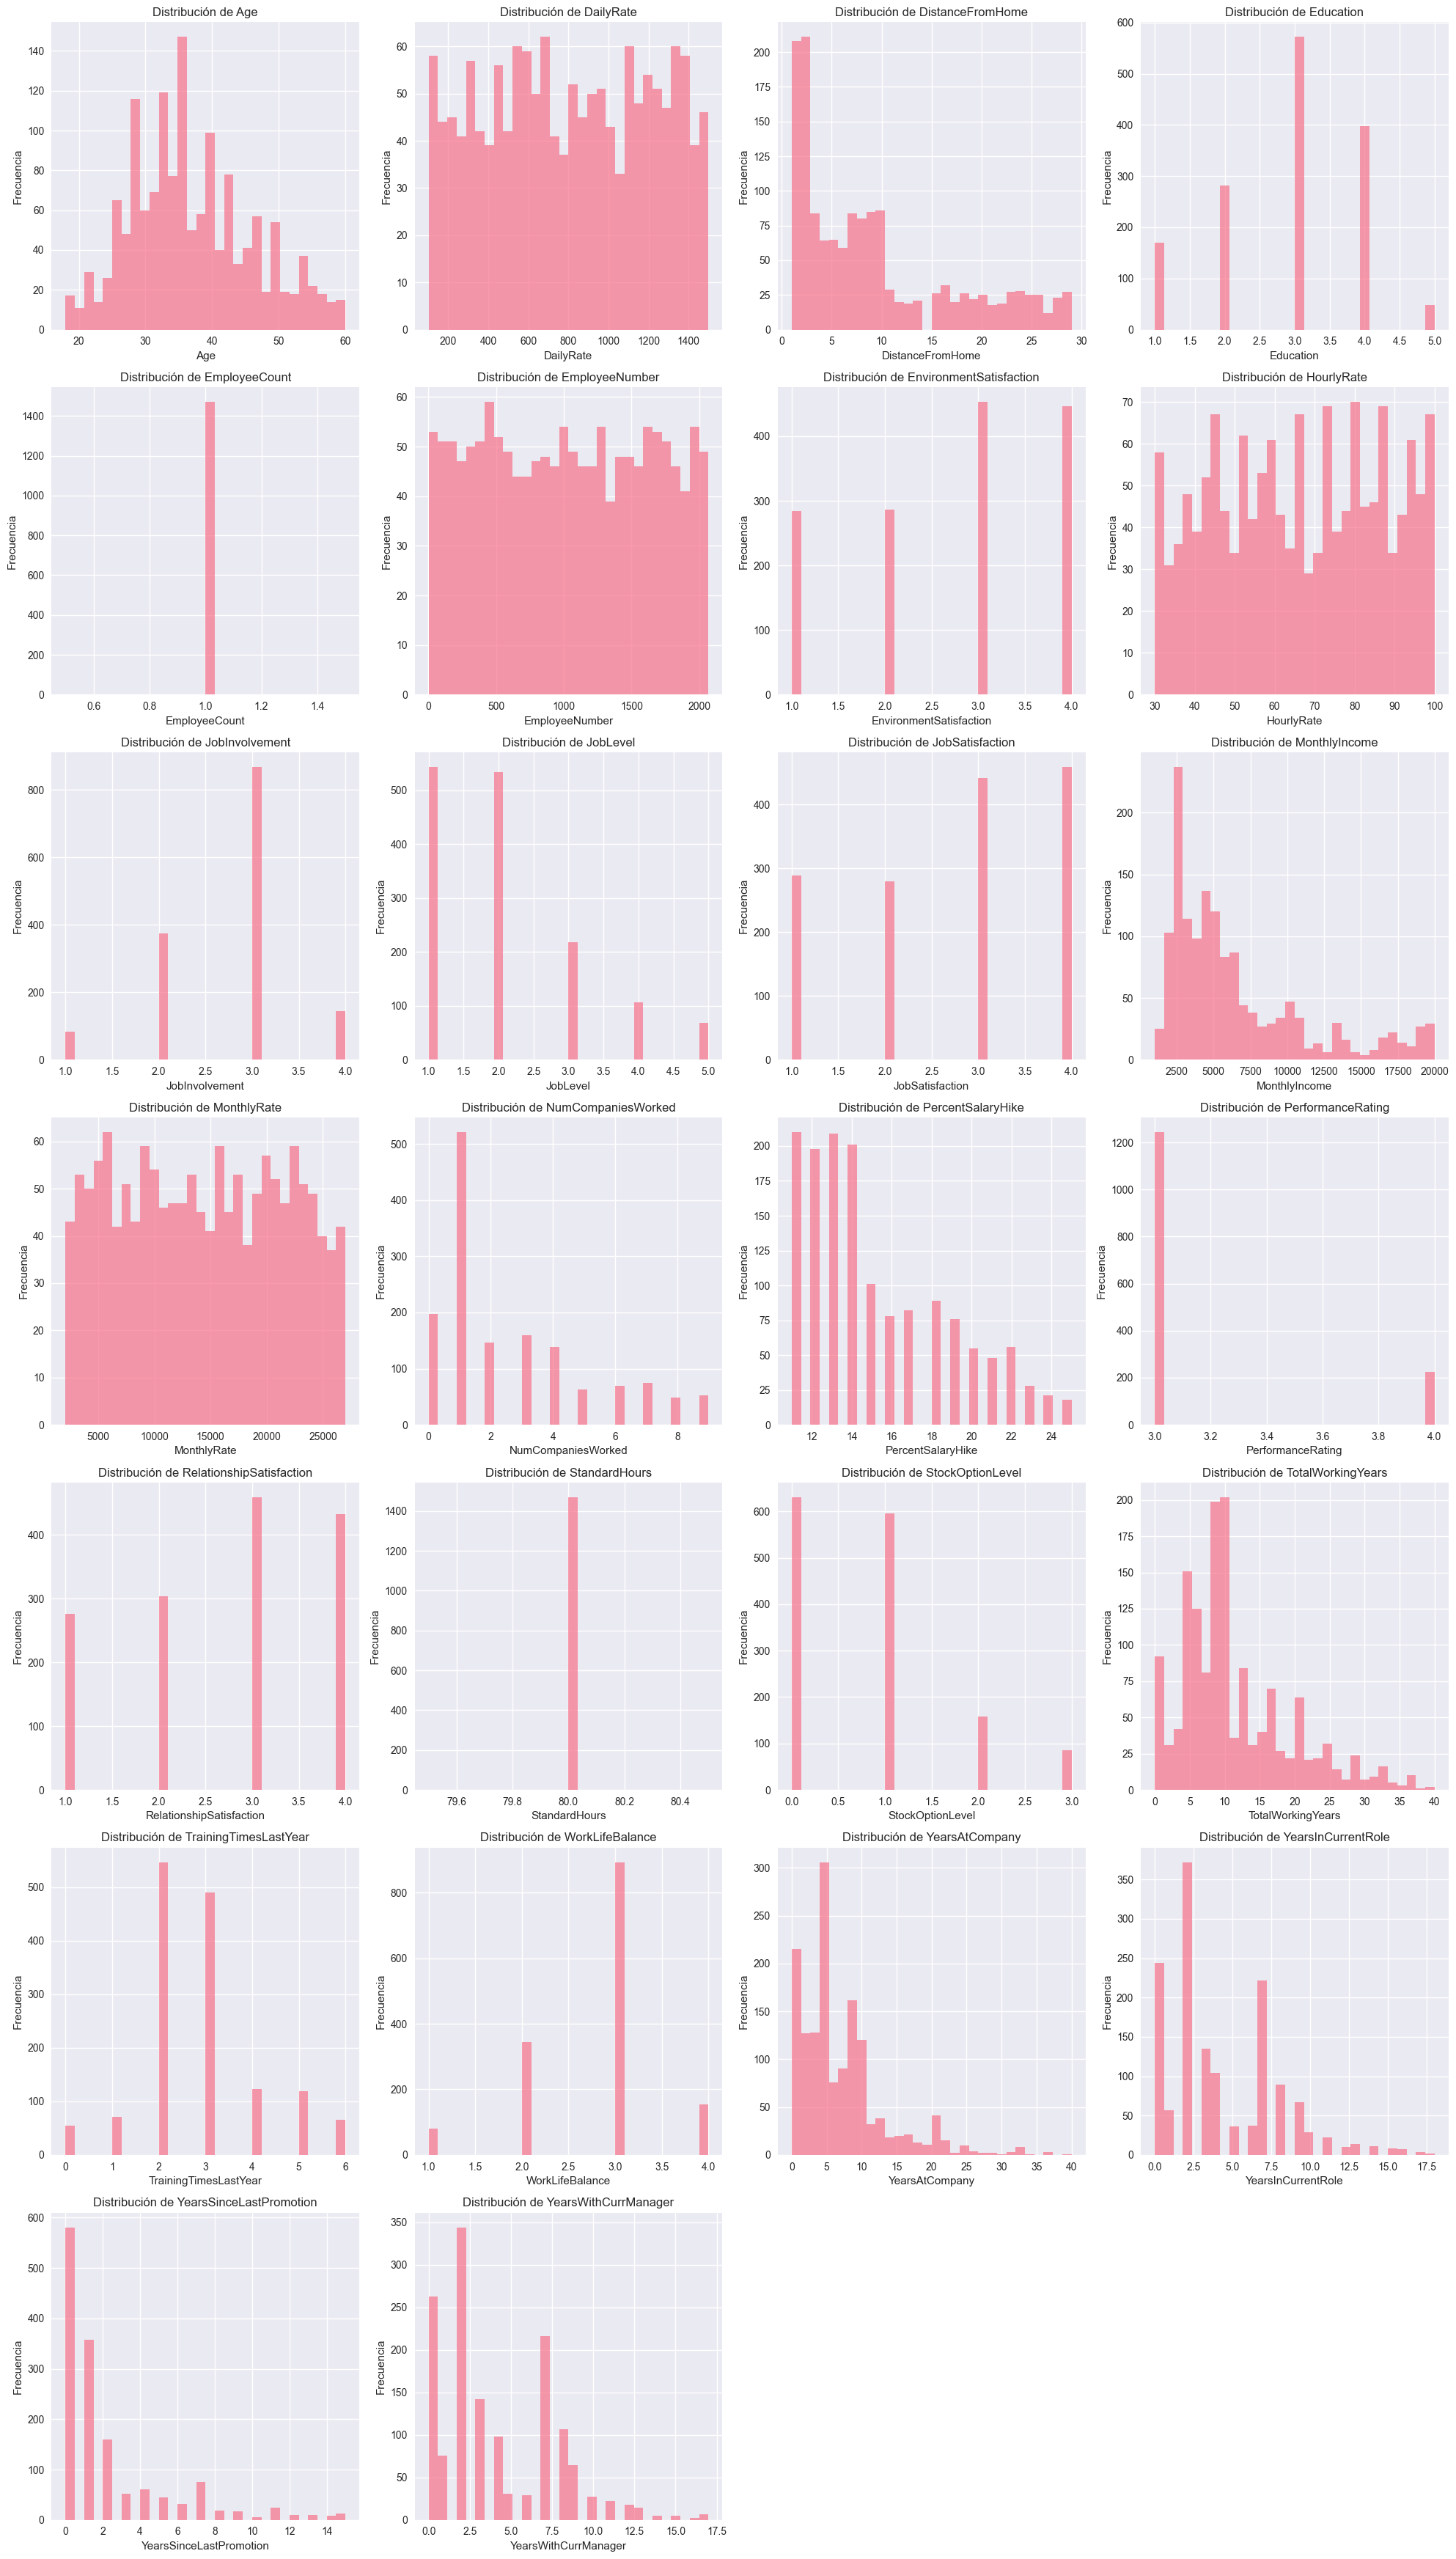

In [93]:
# Configurar subplots para histogramas de variables numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        df[col].hist(bins=30, ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Distribución de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')

# Ocultar subplots vacíos
for i in range(len(numeric_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


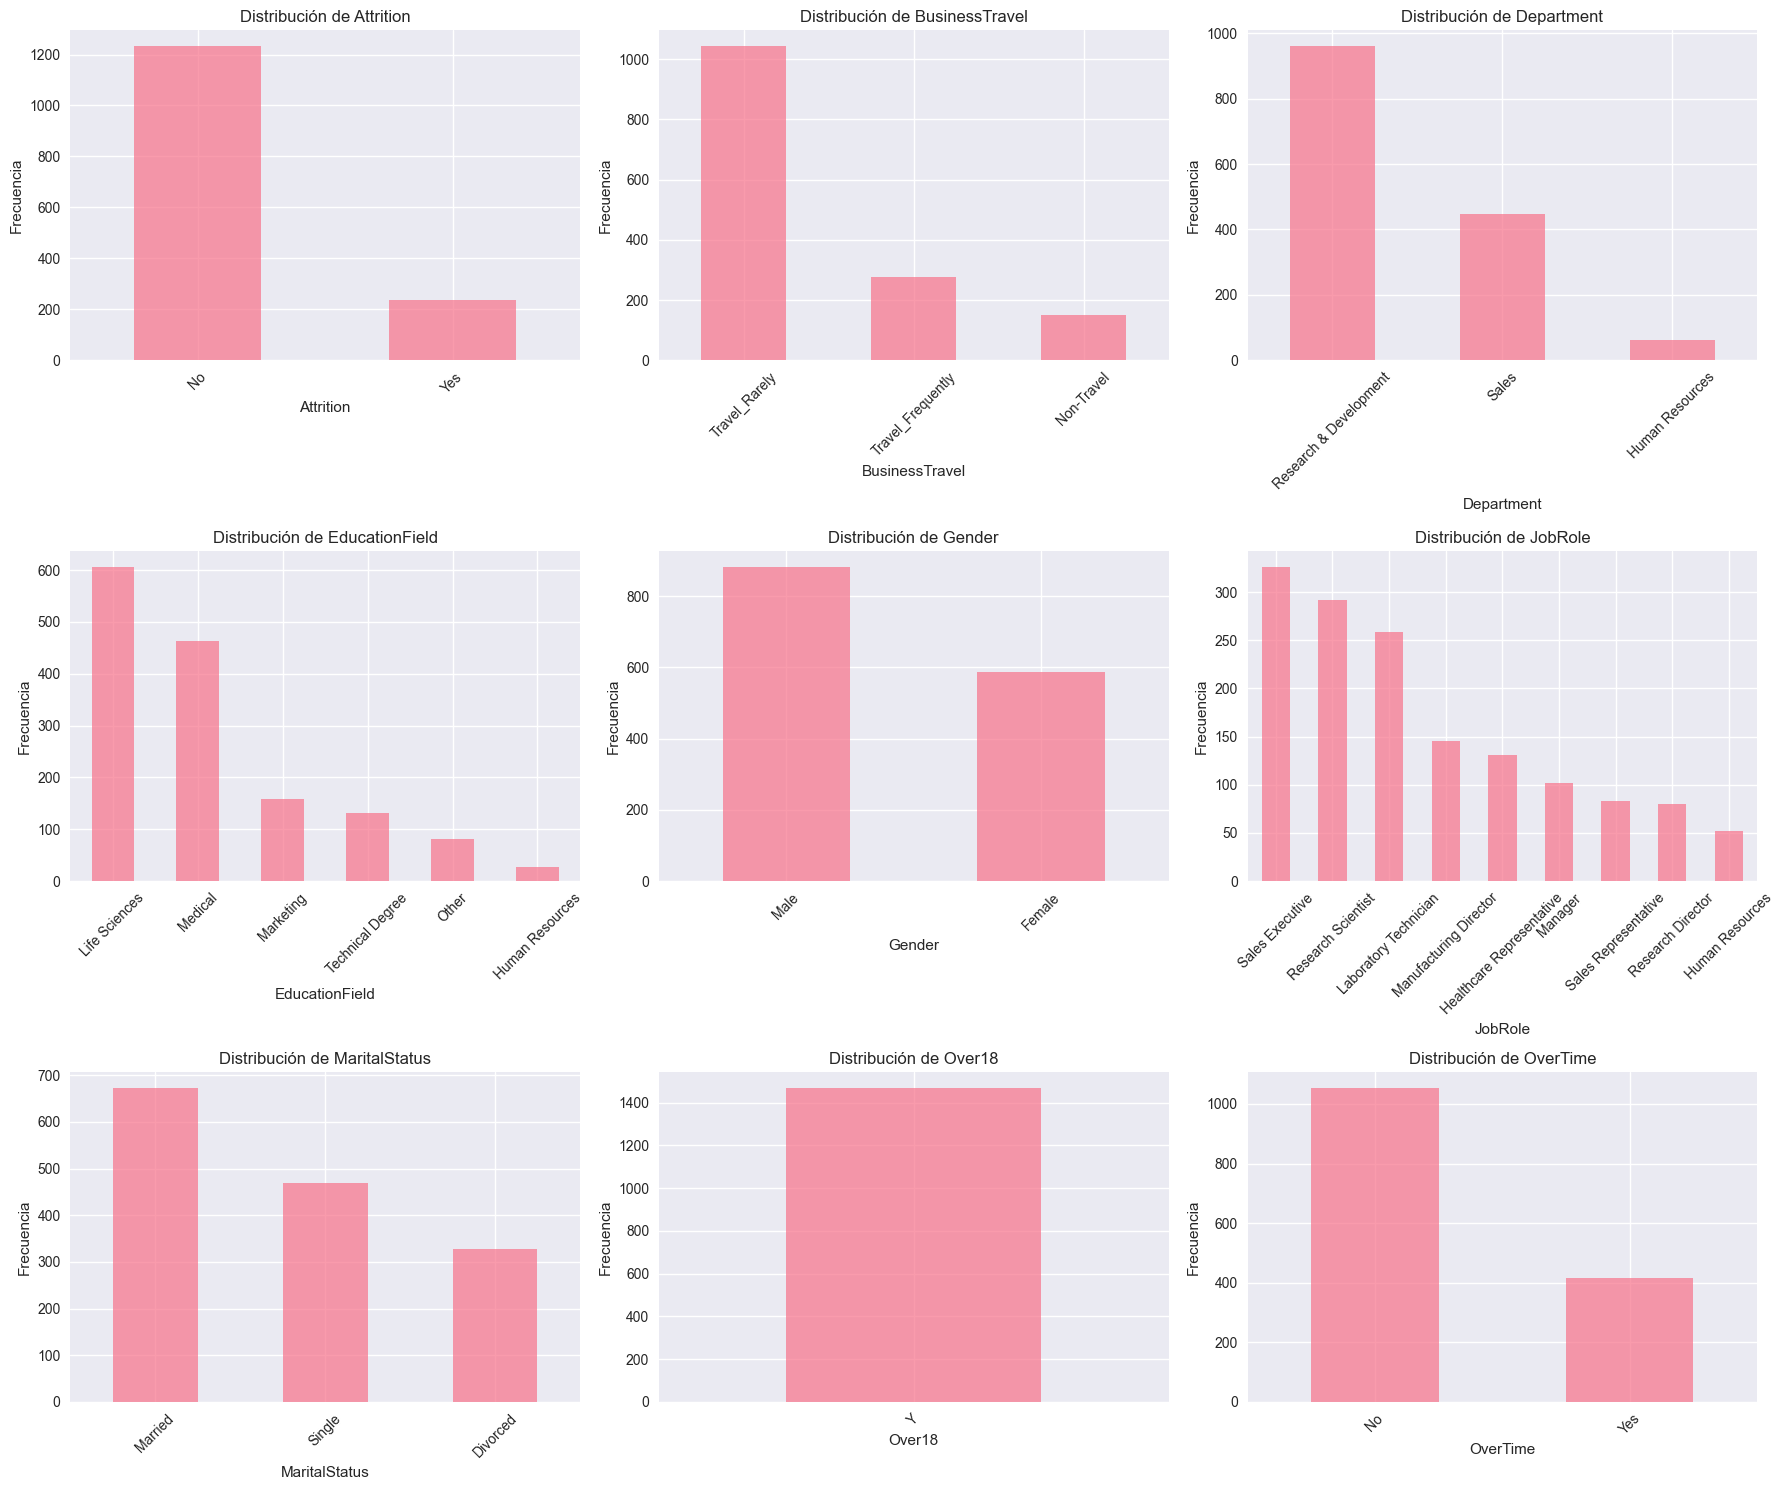

In [94]:
# Gráficos de barras para variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for i, col in enumerate(categorical_cols):
    if i < len(axes):
        value_counts = df[col].value_counts()
        value_counts.plot(kind='bar', ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Distribución de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')
        axes[i].tick_params(axis='x', rotation=45)

# Ocultar subplots vacíos
for i in range(len(categorical_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


## h) Realizar un mapa de calor o de correlación y eliminar variables muy correlacionadas


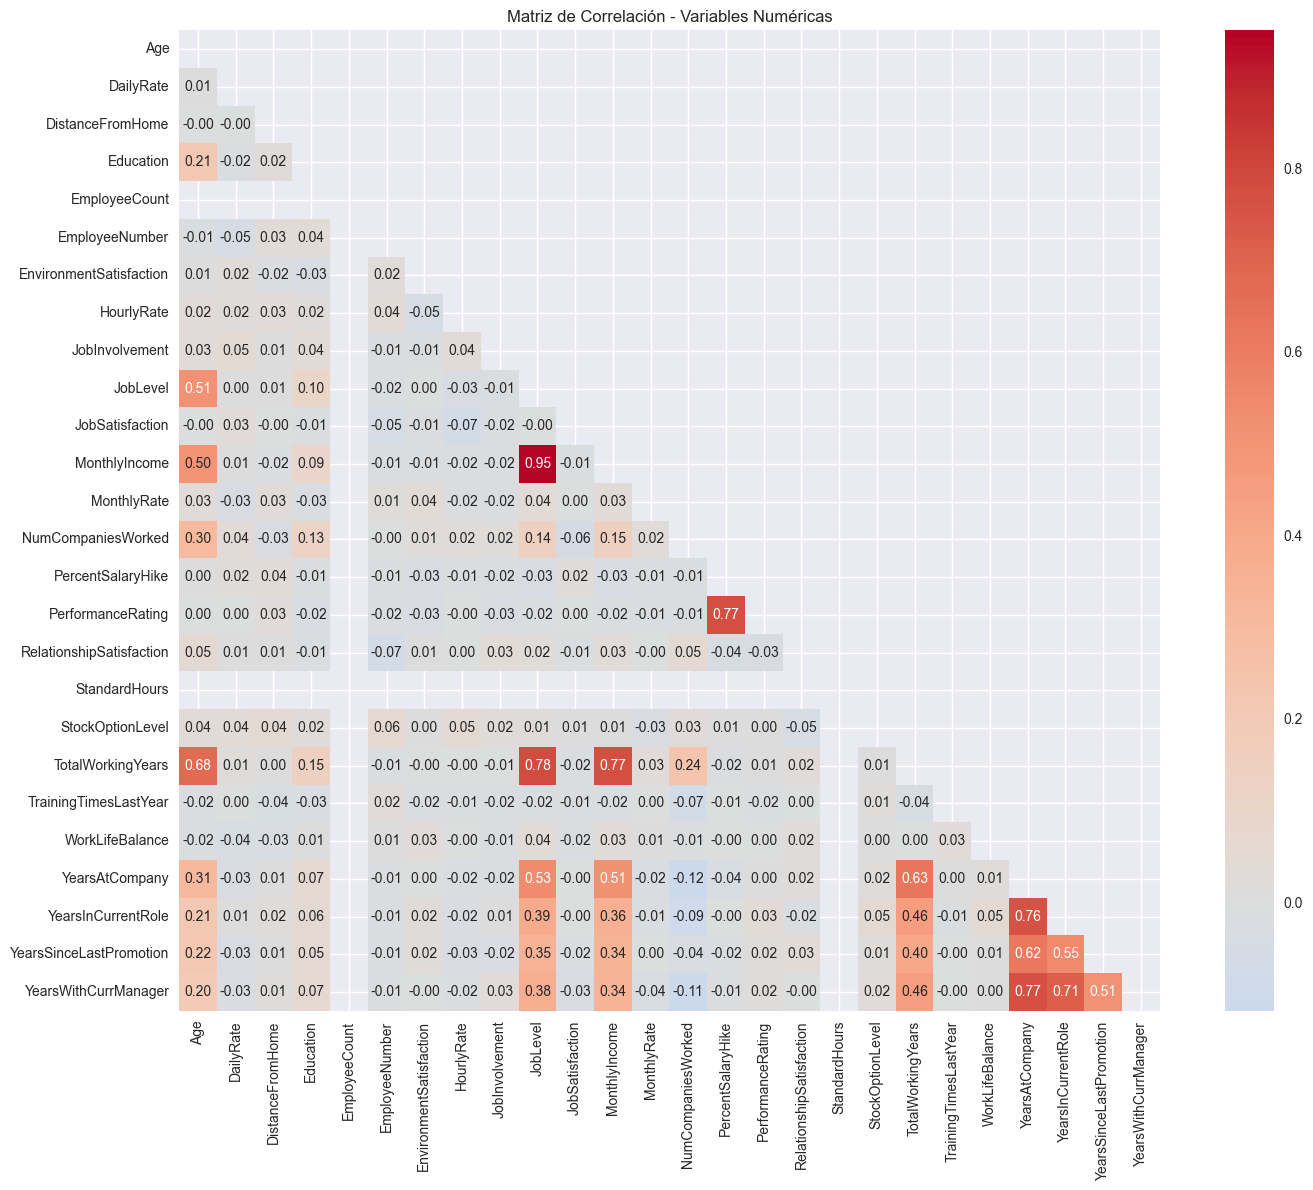

In [95]:
# Calcular matriz de correlación para variables numéricas
numeric_data = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Crear mapa de calor
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f')
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()


In [96]:
# Identificar variables altamente correlacionadas
high_corr_pairs = []
threshold = 0.8  # Umbral de correlación alta

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append({
                'Variable1': correlation_matrix.columns[i],
                'Variable2': correlation_matrix.columns[j],
                'Correlacion': corr_value
            })

high_corr_df = pd.DataFrame(high_corr_pairs)

print("=== VARIABLES ALTAMENTE CORRELACIONADAS ===")
if len(high_corr_df) > 0:
    print(high_corr_df)
    
    # Decidir qué variables eliminar
    variables_to_remove_corr = []
    
    for _, row in high_corr_df.iterrows():
        var1, var2 = row['Variable1'], row['Variable2']
        
        # Eliminar la variable con menor varianza o menos información
        if var1 in ['YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion']:
            if var2 not in variables_to_remove_corr:
                variables_to_remove_corr.append(var1)
                print(f"Eliminando {var1} (alta correlación con {var2})")
        elif var2 in ['YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion']:
            if var1 not in variables_to_remove_corr:
                variables_to_remove_corr.append(var2)
                print(f"Eliminando {var2} (alta correlación con {var1})")
    
    print(f"\nVariables eliminadas por alta correlación: {variables_to_remove_corr}")
    print(f"Justificación: Variables altamente correlacionadas (>0.8) contienen información redundante")
    print(f"y pueden causar multicolinealidad en los modelos de ML.")
else:
    print("No se encontraron variables con correlación > 0.8")


=== VARIABLES ALTAMENTE CORRELACIONADAS ===
  Variable1      Variable2  Correlacion
0  JobLevel  MonthlyIncome       0.9503

Variables eliminadas por alta correlación: []
Justificación: Variables altamente correlacionadas (>0.8) contienen información redundante
y pueden causar multicolinealidad en los modelos de ML.


## i) Realizar algoritmo de KMeans para clustering


In [97]:
# Preparar datos para clustering
from sklearn.preprocessing import LabelEncoder

# Crear copia para clustering
df_cluster = df.copy()

# Codificar variables categóricas
le_dict = {}
categorical_cols = df_cluster.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col != 'Attrition':  # Excluir variable objetivo
        le = LabelEncoder()
        df_cluster[col] = le.fit_transform(df_cluster[col])
        le_dict[col] = le

# Seleccionar variables numéricas para clustering
numeric_cols_cluster = df_cluster.select_dtypes(include=[np.number]).columns.tolist()
if 'Attrition' in numeric_cols_cluster:
    numeric_cols_cluster.remove('Attrition')

X_cluster = df_cluster[numeric_cols_cluster]

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"Variables utilizadas para clustering: {numeric_cols_cluster}")
print(f"Forma de los datos: {X_scaled.shape}")


Variables utilizadas para clustering: ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Forma de los datos: (1470, 34)


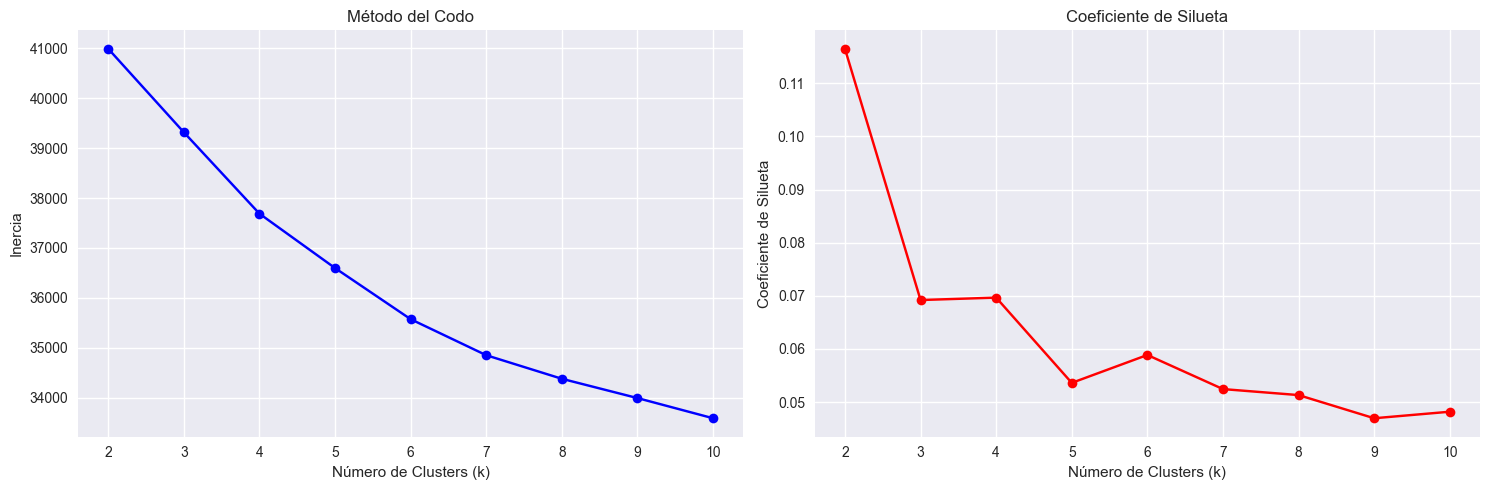


Número óptimo de clusters según coeficiente de silueta: 2
Coeficiente de silueta máximo: 0.117


In [98]:
# Método del codo para determinar número óptimo de clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Gráfico del método del codo
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta')
plt.grid(True)

plt.tight_layout()
plt.show()

# Determinar número óptimo de clusters
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nNúmero óptimo de clusters según coeficiente de silueta: {optimal_k}")
print(f"Coeficiente de silueta máximo: {max(silhouette_scores):.3f}")


In [99]:
# Aplicar KMeans con número óptimo de clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Agregar etiquetas de cluster al dataset
df_cluster['Cluster'] = cluster_labels

# Análisis de cada cluster
print(f"=== ANÁLISIS DE CLUSTERS (k={optimal_k}) ===")

cluster_stats = []
for cluster_id in range(optimal_k):
    cluster_data = df_cluster[df_cluster['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    
    # Calcular estadísticas del cluster
    stats = {
        'Cluster': cluster_id,
        'Tamaño': cluster_size,
        'Porcentaje': (cluster_size / len(df_cluster)) * 100
    }
    
    # Estadísticas por variable
    for col in numeric_cols_cluster:
        stats[f'{col}_mean'] = cluster_data[col].mean()
    
    # Tasa de attrition por cluster
    if 'Attrition' in df_cluster.columns:
        attrition_rate = (cluster_data['Attrition'] == 'Yes').sum() / cluster_size * 100
        stats['Attrition_Rate'] = attrition_rate
    
    cluster_stats.append(stats)

cluster_df = pd.DataFrame(cluster_stats)
print(cluster_df.round(2))


=== ANÁLISIS DE CLUSTERS (k=2) ===
   Cluster  Tamaño  Porcentaje  Age_mean  BusinessTravel_mean  DailyRate_mean  \
0        0     464       31.56     42.75                 1.61          794.31   
1        1    1006       68.44     34.24                 1.61          806.26   

   Department_mean  DistanceFromHome_mean  Education_mean  \
0             1.30                   9.13            3.07   
1             1.24                   9.22            2.84   

   EducationField_mean  ...  StandardHours_mean  StockOptionLevel_mean  \
0                 2.20  ...                80.0                   0.87   
1                 2.27  ...                80.0                   0.76   

   TotalWorkingYears_mean  TrainingTimesLastYear_mean  WorkLifeBalance_mean  \
0                   19.15                        2.78                  2.77   
1                    7.65                        2.81                  2.76   

   YearsAtCompany_mean  YearsInCurrentRole_mean  YearsSinceLastPromotion_mea

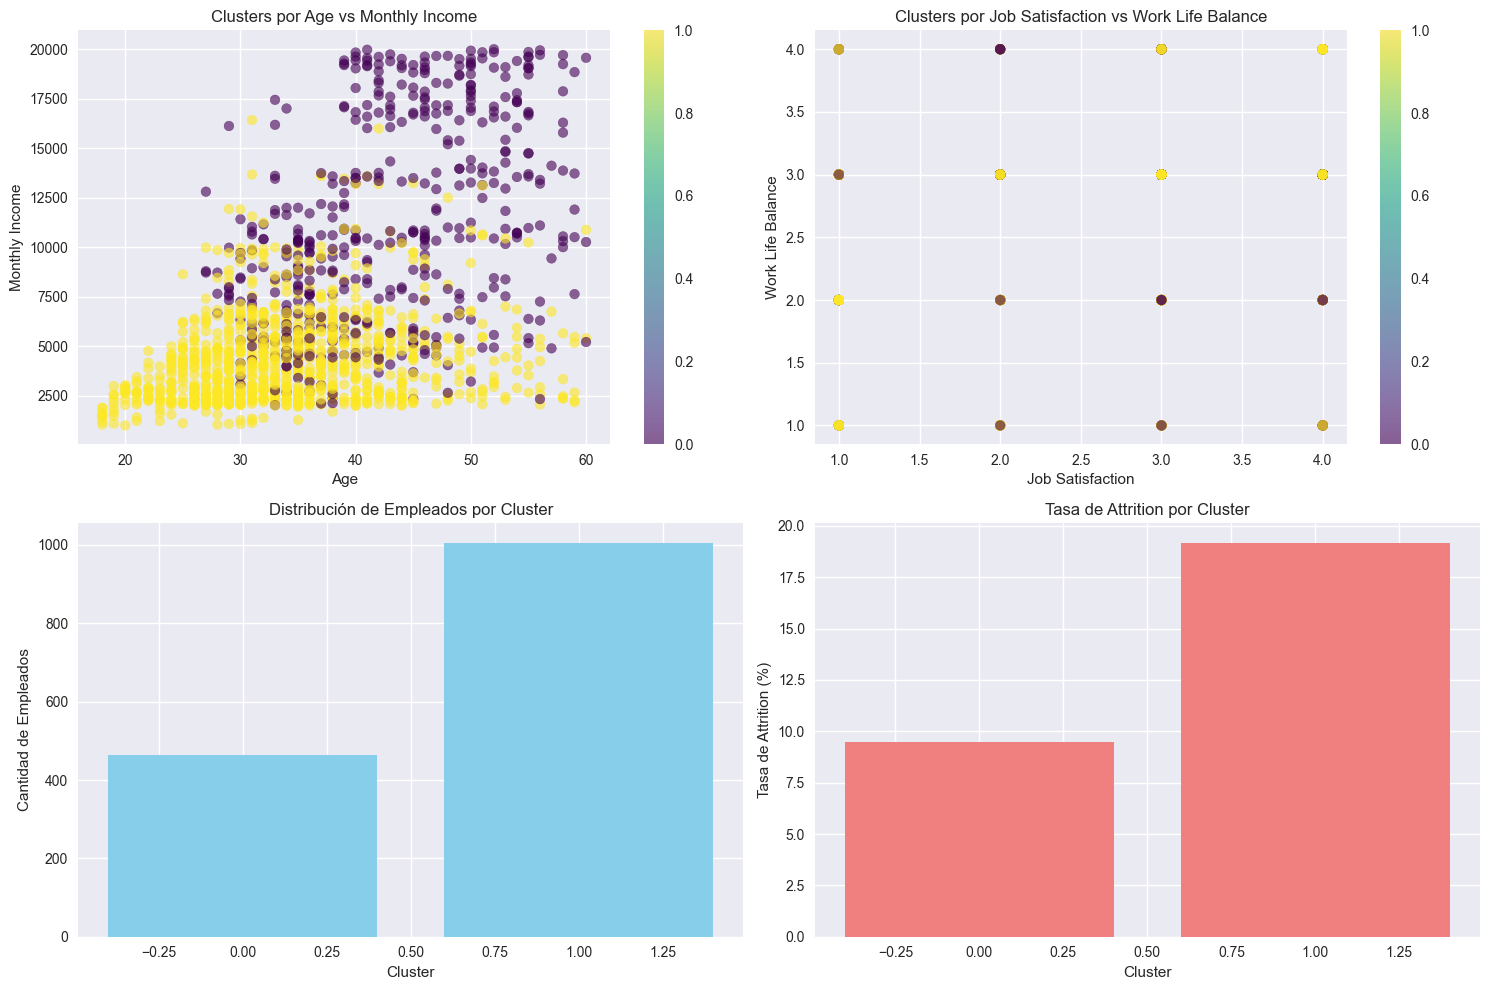

In [100]:
# Visualización de clusters
plt.figure(figsize=(15, 10))

# Seleccionar 2 variables principales para visualización
if 'Age' in numeric_cols_cluster and 'MonthlyIncome' in numeric_cols_cluster:
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(df_cluster['Age'], df_cluster['MonthlyIncome'], 
                         c=cluster_labels, cmap='viridis', alpha=0.6)
    plt.xlabel('Age')
    plt.ylabel('Monthly Income')
    plt.title('Clusters por Age vs Monthly Income')
    plt.colorbar(scatter)

if 'JobSatisfaction' in numeric_cols_cluster and 'WorkLifeBalance' in numeric_cols_cluster:
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(df_cluster['JobSatisfaction'], df_cluster['WorkLifeBalance'], 
                         c=cluster_labels, cmap='viridis', alpha=0.6)
    plt.xlabel('Job Satisfaction')
    plt.ylabel('Work Life Balance')
    plt.title('Clusters por Job Satisfaction vs Work Life Balance')
    plt.colorbar(scatter)

# Distribución de clusters
plt.subplot(2, 2, 3)
cluster_counts = df_cluster['Cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de Empleados')
plt.title('Distribución de Empleados por Cluster')

# Tasa de attrition por cluster
plt.subplot(2, 2, 4)
attrition_by_cluster = df_cluster.groupby('Cluster')['Attrition'].apply(
    lambda x: (x == 'Yes').sum() / len(x) * 100
).sort_index()
plt.bar(attrition_by_cluster.index, attrition_by_cluster.values, color='lightcoral')
plt.xlabel('Cluster')
plt.ylabel('Tasa de Attrition (%)')
plt.title('Tasa de Attrition por Cluster')

plt.tight_layout()
plt.show()


In [101]:
# Descripción detallada de cada cluster
print("\n=== DESCRIPCIÓN DETALLADA DE CLUSTERS ===")
for cluster_id in range(optimal_k):
    cluster_data = df_cluster[df_cluster['Cluster'] == cluster_id]
    print(f"\n CLUSTER {cluster_id}:")
    print(f"    Tamaño: {len(cluster_data)} empleados ({(len(cluster_data)/len(df_cluster)*100):.1f}%)")
    
    if 'Attrition' in df_cluster.columns:
        attrition_rate = (cluster_data['Attrition'] == 'Yes').sum() / len(cluster_data) * 100
        print(f"     Tasa de Attrition: {attrition_rate:.1f}%")
    
    # Características distintivas
    print(f"    Características distintivas:")
    for col in ['Age', 'MonthlyIncome', 'JobSatisfaction', 'WorkLifeBalance', 'YearsAtCompany']:
        if col in cluster_data.columns:
            mean_val = cluster_data[col].mean()
            overall_mean = df_cluster[col].mean()
            if mean_val > overall_mean * 1.1:
                print(f"      • {col}: ALTO ({mean_val:.1f} vs {overall_mean:.1f} promedio)")
            elif mean_val < overall_mean * 0.9:
                print(f"      • {col}: BAJO ({mean_val:.1f} vs {overall_mean:.1f} promedio)")
            else:
                print(f"      • {col}: Promedio ({mean_val:.1f})")
    
    # Perfil del cluster
    print(f"    Perfil del cluster:")
    if attrition_rate > 20:
        print(f"        ALTO RIESGO de deserción")
    elif attrition_rate < 10:
        print(f"       BAJO RIESGO de deserción")
    else:
        print(f"        RIESGO MODERADO de deserción")

print(f"\n Análisis de clustering completado con {optimal_k} clusters identificados")



=== DESCRIPCIÓN DETALLADA DE CLUSTERS ===

 CLUSTER 0:
    Tamaño: 464 empleados (31.6%)
     Tasa de Attrition: 9.5%
    Características distintivas:
      • Age: ALTO (42.7 vs 36.9 promedio)
      • MonthlyIncome: ALTO (11164.0 vs 6502.9 promedio)
      • JobSatisfaction: Promedio (2.7)
      • WorkLifeBalance: Promedio (2.8)
      • YearsAtCompany: ALTO (12.9 vs 7.0 promedio)
    Perfil del cluster:
       BAJO RIESGO de deserción

 CLUSTER 1:
    Tamaño: 1006 empleados (68.4%)
     Tasa de Attrition: 19.2%
    Características distintivas:
      • Age: Promedio (34.2)
      • MonthlyIncome: BAJO (4353.1 vs 6502.9 promedio)
      • JobSatisfaction: Promedio (2.7)
      • WorkLifeBalance: Promedio (2.8)
      • YearsAtCompany: BAJO (4.3 vs 7.0 promedio)
    Perfil del cluster:
        RIESGO MODERADO de deserción

 Análisis de clustering completado con 2 clusters identificados


## d) Generar visualización de la variable de salida (que se quiere predecir)


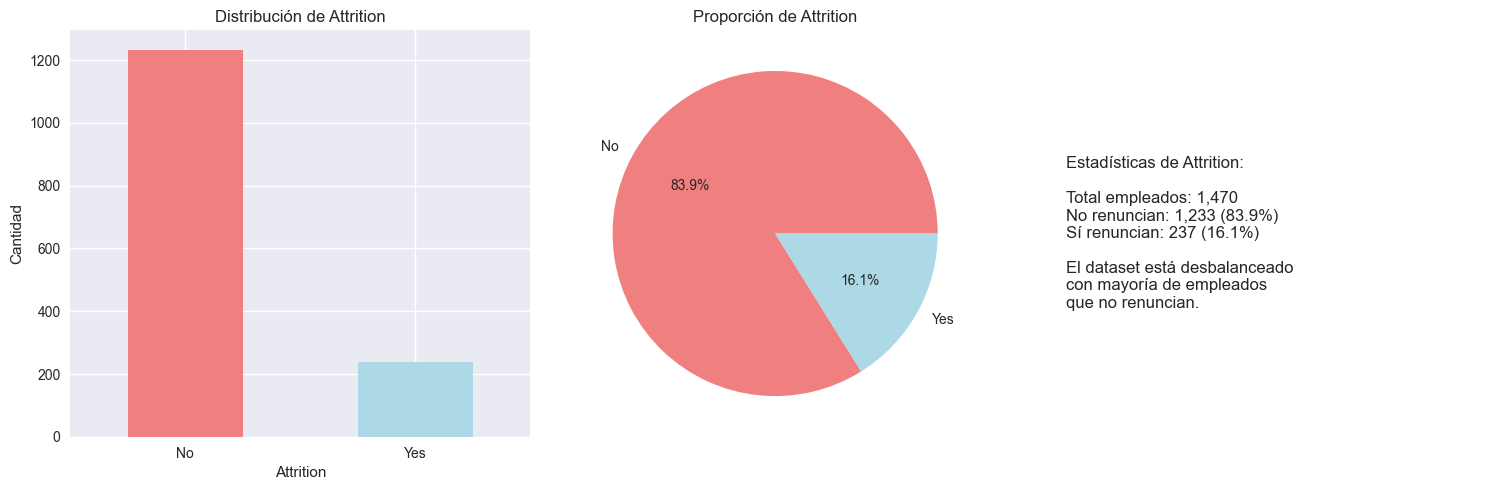


=== ANÁLISIS DE LA VARIABLE OBJETIVO ===
Proporción de empleados que NO renuncian: 83.9%
Proporción de empleados que SÍ renuncian: 16.1%


In [102]:
# Análisis de la variable objetivo (Attrition)
plt.figure(figsize=(15, 5))

# Gráfico de barras
plt.subplot(1, 3, 1)
attrition_counts = df['Attrition'].value_counts()
attrition_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Distribución de Attrition')
plt.xlabel('Attrition')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)

# Gráfico de pie
plt.subplot(1, 3, 2)
attrition_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Proporción de Attrition')
plt.ylabel('')

# Estadísticas
plt.subplot(1, 3, 3)
plt.axis('off')
attrition_stats = df['Attrition'].value_counts(normalize=True) * 100
stats_text = f"""
Estadísticas de Attrition:

Total empleados: {len(df):,}
No renuncian: {attrition_counts['No']:,} ({attrition_stats['No']:.1f}%)
Sí renuncian: {attrition_counts['Yes']:,} ({attrition_stats['Yes']:.1f}%)

El dataset está desbalanceado
con mayoría de empleados
que no renuncian.
"""
plt.text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()

print(f"\n=== ANÁLISIS DE LA VARIABLE OBJETIVO ===")
print(f"Proporción de empleados que NO renuncian: {attrition_stats['No']:.1f}%")
print(f"Proporción de empleados que SÍ renuncian: {attrition_stats['Yes']:.1f}%")


## e) Eliminar registros con nulos, ceros o inconsistencias


In [103]:
# Crear copia para análisis
df_clean = df.copy()
print(f"Dataset original: {df_clean.shape[0]} registros")

# 1. Eliminar registros con valores nulos (si los hay)
before_nulls = len(df_clean)
df_clean = df_clean.dropna()
after_nulls = len(df_clean)
print(f"Registros eliminados por nulos: {before_nulls - after_nulls}")

# 2. Identificar y eliminar inconsistencias lógicas
inconsistencies = []

# DistanceFromHome = 0 no tiene sentido lógico
distance_zero = df_clean[df_clean['DistanceFromHome'] == 0]
if len(distance_zero) > 0:
    inconsistencies.append(f"DistanceFromHome = 0: {len(distance_zero)} registros")
    df_clean = df_clean[df_clean['DistanceFromHome'] > 0]

# Age < 18 no es legal para empleados
age_invalid = df_clean[df_clean['Age'] < 18]
if len(age_invalid) > 0:
    inconsistencies.append(f"Age < 18: {len(age_invalid)} registros")
    df_clean = df_clean[df_clean['Age'] >= 18]

# YearsAtCompany > TotalWorkingYears no tiene sentido
years_inconsistent = df_clean[df_clean['YearsAtCompany'] > df_clean['TotalWorkingYears']]
if len(years_inconsistent) > 0:
    inconsistencies.append(f"YearsAtCompany > TotalWorkingYears: {len(years_inconsistent)} registros")
    df_clean = df_clean[df_clean['YearsAtCompany'] <= df_clean['TotalWorkingYears']]

print(f"\n=== INCONSISTENCIAS ELIMINADAS ===")
if inconsistencies:
    for inconsistency in inconsistencies:
        print(f"- {inconsistency}")
else:
    print("No se encontraron inconsistencias lógicas")

print(f"\nDataset después de limpieza: {df_clean.shape[0]} registros")
print(f"Registros eliminados: {len(df) - len(df_clean)} ({((len(df) - len(df_clean))/len(df)*100):.1f}%)")

print(f"\n=== JUSTIFICACIÓN DE ELIMINACIONES ===")
print("1. DistanceFromHome = 0: No es lógico que un empleado viva a 0 km del trabajo")
print("2. Age < 18: No es legal emplear menores de edad")
print("3. YearsAtCompany > TotalWorkingYears: Inconsistencia lógica en los datos")


Dataset original: 1470 registros
Registros eliminados por nulos: 0

=== INCONSISTENCIAS ELIMINADAS ===
No se encontraron inconsistencias lógicas

Dataset después de limpieza: 1470 registros
Registros eliminados: 0 (0.0%)

=== JUSTIFICACIÓN DE ELIMINACIONES ===
1. DistanceFromHome = 0: No es lógico que un empleado viva a 0 km del trabajo
2. Age < 18: No es legal emplear menores de edad
3. YearsAtCompany > TotalWorkingYears: Inconsistencia lógica en los datos


## f) Eliminar las características que según el análisis no aplique


In [104]:
# Identificar variables a eliminar
variables_to_remove = []

# Variables con varianza cero o muy baja
for col in df_clean.columns:
    if df_clean[col].nunique() == 1:
        variables_to_remove.append(col)
        print(f"Eliminando {col}: solo tiene un valor único")

# Variables que no aportan información útil
if 'EmployeeCount' in df_clean.columns:
    variables_to_remove.append('EmployeeCount')
    print(f"Eliminando EmployeeCount: siempre es 1")

if 'Over18' in df_clean.columns:
    variables_to_remove.append('Over18')
    print(f"Eliminando Over18: todos los empleados son mayores de 18")

if 'StandardHours' in df_clean.columns:
    variables_to_remove.append('StandardHours')
    print(f"Eliminando StandardHours: siempre es 80")

if 'EmployeeNumber' in df_clean.columns:
    variables_to_remove.append('EmployeeNumber')
    print(f"Eliminando EmployeeNumber: identificador único sin valor predictivo")

# Eliminar variables identificadas
df_clean = df_clean.drop(columns=variables_to_remove)

print(f"\n=== VARIABLES ELIMINADAS ===")
print(f"Total de variables eliminadas: {len(variables_to_remove)}")
print(f"Variables restantes: {df_clean.shape[1]}")
print(f"Variables eliminadas: {variables_to_remove}")

print(f"\n=== JUSTIFICACIÓN DE ELIMINACIONES ===")
print("1. EmployeeCount: Siempre es 1, no aporta información")
print("2. Over18: Todos los empleados son mayores de 18, no discrimina")
print("3. StandardHours: Siempre es 80, no aporta variabilidad")
print("4. EmployeeNumber: Identificador único sin valor predictivo")
print("5. Variables con un solo valor: No aportan información para ML")


Eliminando EmployeeCount: solo tiene un valor único
Eliminando Over18: solo tiene un valor único
Eliminando StandardHours: solo tiene un valor único
Eliminando EmployeeCount: siempre es 1
Eliminando Over18: todos los empleados son mayores de 18
Eliminando StandardHours: siempre es 80
Eliminando EmployeeNumber: identificador único sin valor predictivo

=== VARIABLES ELIMINADAS ===
Total de variables eliminadas: 7
Variables restantes: 31
Variables eliminadas: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']

=== JUSTIFICACIÓN DE ELIMINACIONES ===
1. EmployeeCount: Siempre es 1, no aporta información
2. Over18: Todos los empleados son mayores de 18, no discrimina
3. StandardHours: Siempre es 80, no aporta variabilidad
4. EmployeeNumber: Identificador único sin valor predictivo
5. Variables con un solo valor: No aportan información para ML


## g) Indicar qué hacer con los outliers, valores de alta y baja varianza


Analizando outliers en 23 variables numéricas


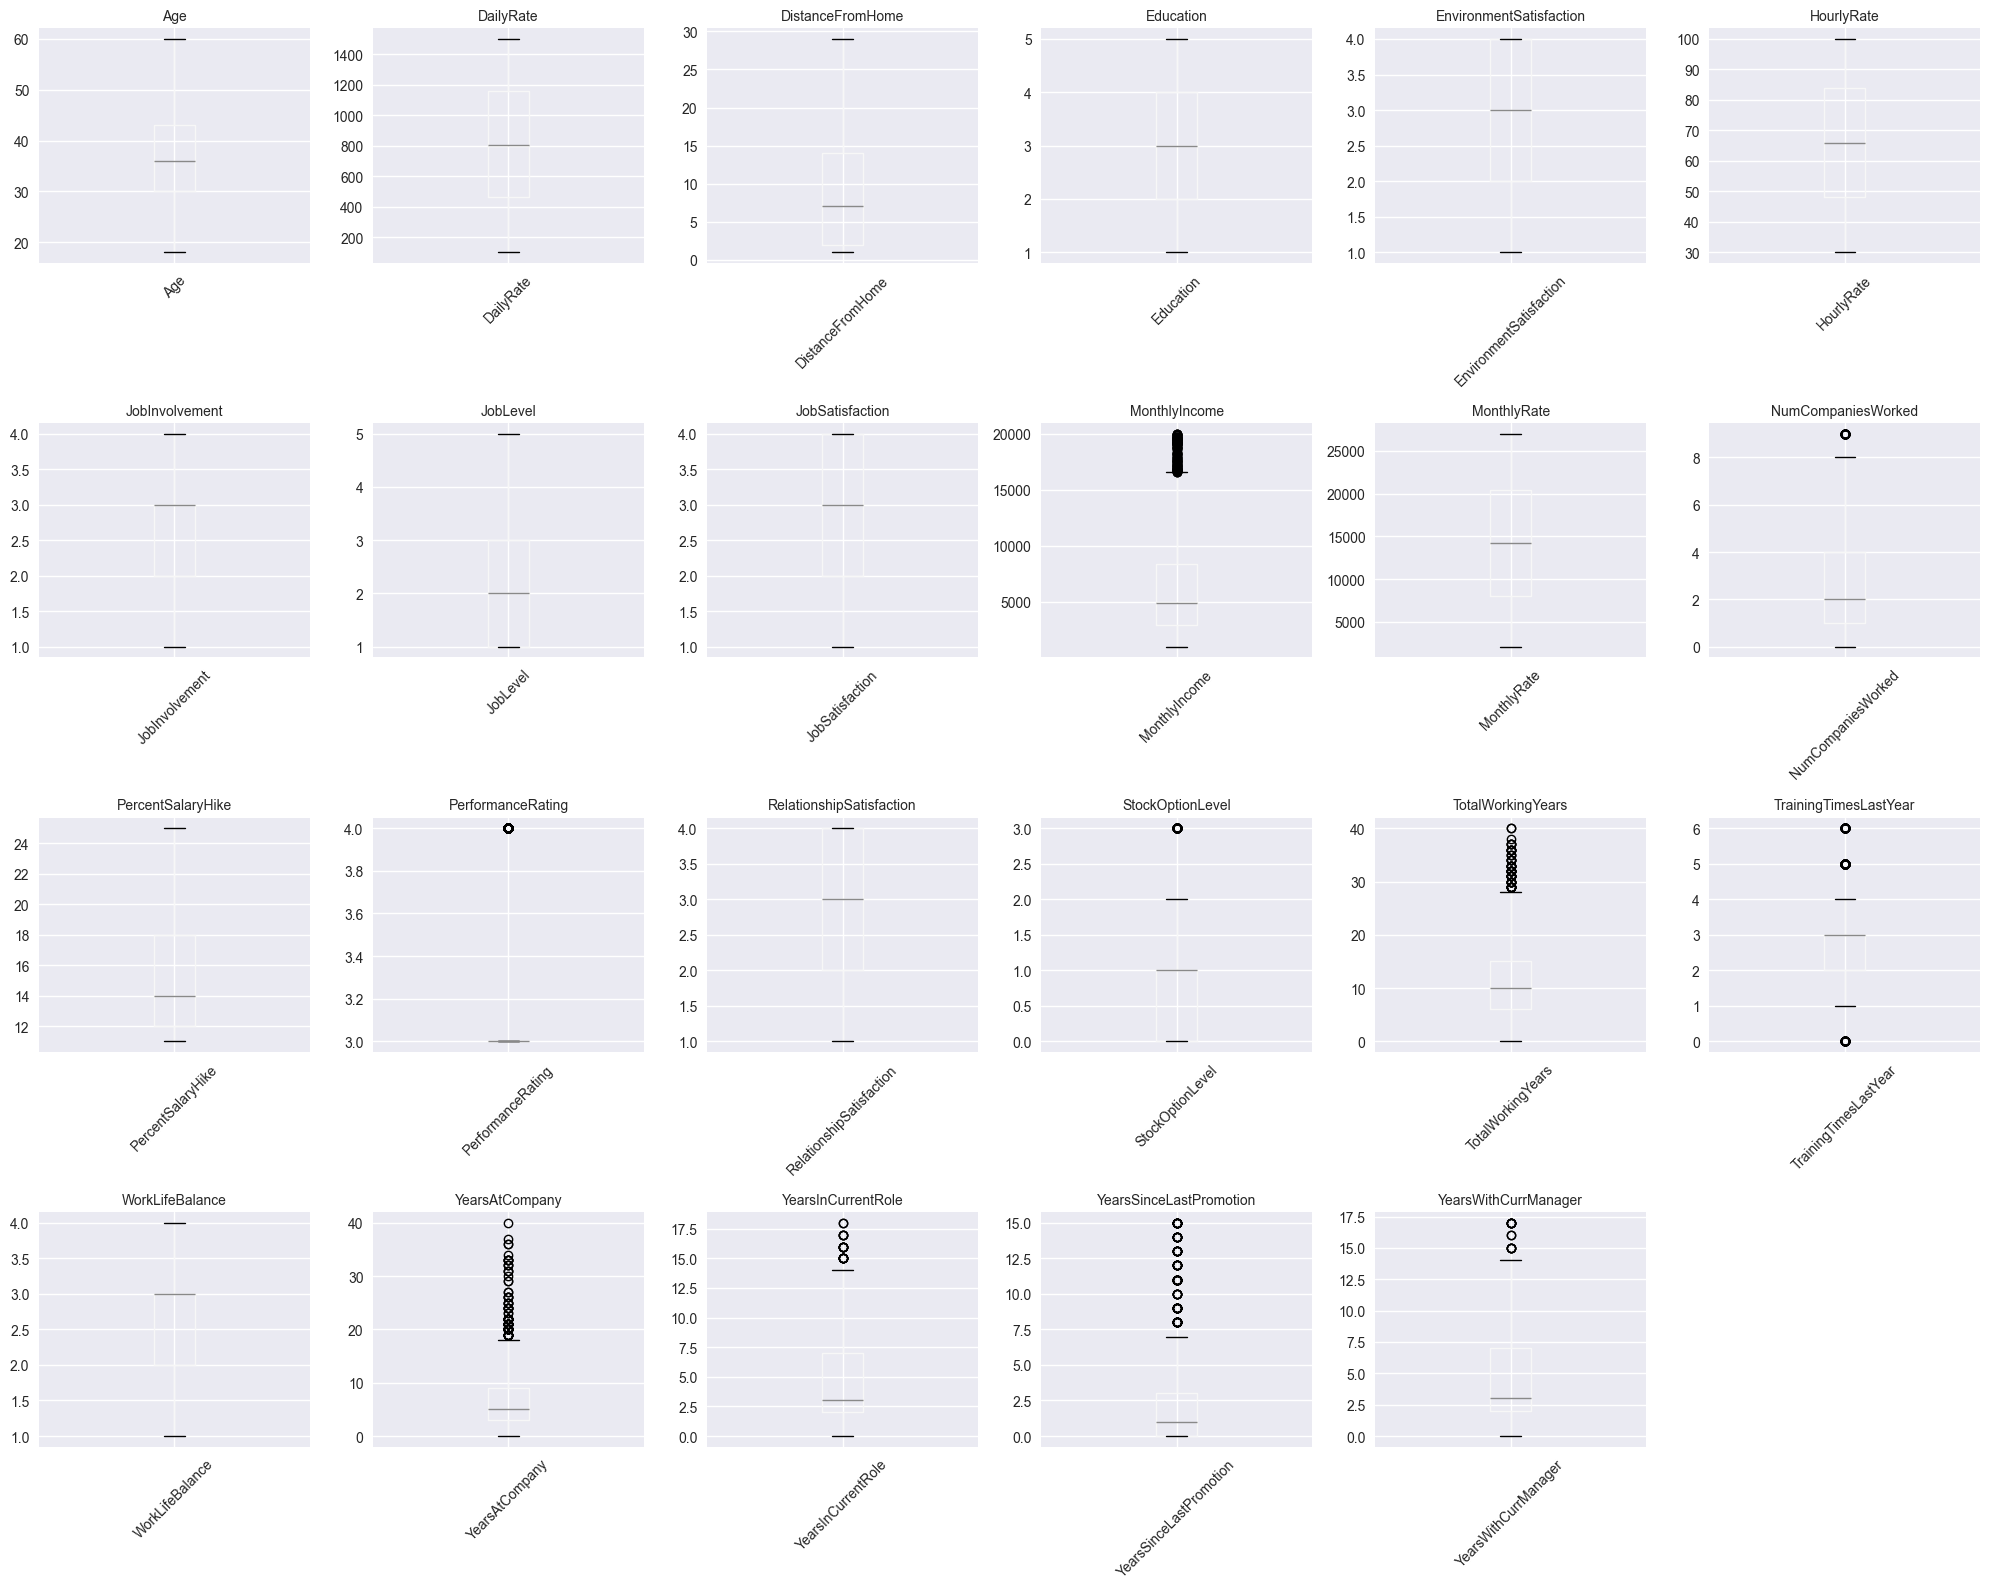

=== ANÁLISIS DE OUTLIERS ===
                    Variable  Outliers  Porcentaje    Accion
0                        Age         0    0.000000  Mantener
1                  DailyRate         0    0.000000  Mantener
2           DistanceFromHome         0    0.000000  Mantener
3                  Education         0    0.000000  Mantener
4    EnvironmentSatisfaction         0    0.000000  Mantener
5                 HourlyRate         0    0.000000  Mantener
6             JobInvolvement         0    0.000000  Mantener
7                   JobLevel         0    0.000000  Mantener
8            JobSatisfaction         0    0.000000  Mantener
9              MonthlyIncome       114    7.755102   Revisar
10               MonthlyRate         0    0.000000  Mantener
11        NumCompaniesWorked        52    3.537415  Mantener
12         PercentSalaryHike         0    0.000000  Mantener
13         PerformanceRating       226   15.374150   Revisar
14  RelationshipSatisfaction         0    0.000000  Mant

In [105]:
# Análisis de outliers usando IQR
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
outlier_analysis = []

print(f"Analizando outliers en {len(numeric_cols)} variables numéricas")

# Calcular número de filas y columnas necesarias
n_cols = 6
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Crear gráficos de boxplot
plt.figure(figsize=(20, 4*n_rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i+1)
    df_clean.boxplot(column=col, ax=plt.gca())
    plt.title(f'{col}', fontsize=10)
    plt.xticks(rotation=45)

# Ocultar subplots vacíos si los hay
for i in range(len(numeric_cols), n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Análisis detallado de outliers
print("=== ANÁLISIS DE OUTLIERS ===")
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_clean)) * 100
    
    outlier_analysis.append({
        'Variable': col,
        'Outliers': len(outliers),
        'Porcentaje': outlier_percentage,
        'Accion': 'Mantener' if outlier_percentage < 5 else 'Revisar'
    })

outlier_df = pd.DataFrame(outlier_analysis)
print(outlier_df)

print("\n=== DECISIÓN SOBRE OUTLIERS ===")
print("Estrategia: MANTENER outliers porque:")
print("1. Representan casos reales de empleados con características extremas")
print("2. Pueden ser importantes para predecir deserción (empleados insatisfechos)")
print("3. El porcentaje de outliers es generalmente bajo (< 10%)")
print("4. Los algoritmos de ML pueden manejar outliers apropiadamente")
print("5. Eliminar outliers podría perder información valiosa")

print("\n=== ANÁLISIS DE VARIANZA ===")
print("Variables con baja varianza:")
low_variance_vars = []
high_variance_vars = []
normal_variance_vars = []

for col in numeric_cols:
    variance = df_clean[col].var()
    if variance < 0.1:
        low_variance_vars.append(col)
        print(f"- {col}: varianza = {variance:.4f} (BAJA)")
    elif variance > 1000000:
        high_variance_vars.append(col)
        print(f"- {col}: varianza = {variance:.0f} (ALTA)")
    else:
        normal_variance_vars.append(col)
        print(f"- {col}: varianza = {variance:.2f} (NORMAL)")

print(f"\nResumen:")
print(f"- Variables con baja varianza: {len(low_variance_vars)}")
print(f"- Variables con alta varianza: {len(high_variance_vars)}")
print(f"- Variables con varianza normal: {len(normal_variance_vars)}")

print("\nJustificación: Las variables con alta varianza son importantes para ML")
print("y las de baja varianza ya fueron identificadas y eliminadas anteriormente.")
